# Oil Seep Detection 

In [0]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import cv2
import os

In [2]:
tf.test.is_gpu_available()

True

## Explore Dataset

In [0]:
def plot_image_mask(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

(790, 256, 256, 3)


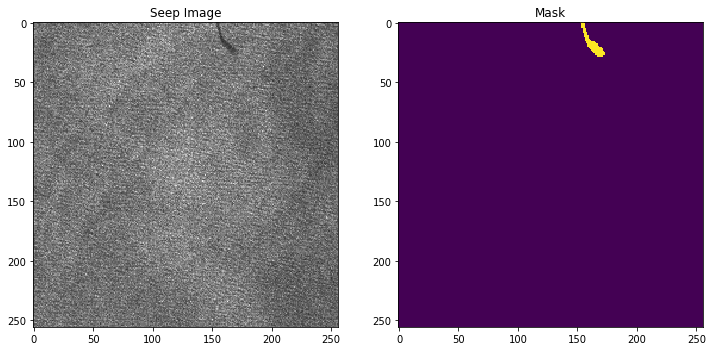

In [4]:
idx = 1

img_path = "seep_detection/images/train_images_256/"
mask_path = "seep_detection/masks/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
  images.append(cv2.cvtColor(cv2.imread(img_path + filename), cv2.COLOR_BGR2RGB))
  masks.append(plt.imread(mask_path + filename))

images = np.array(images)
masks = np.array(masks)

print(images.shape)
plot_image_mask(images[idx], masks[idx])

In [5]:
print("Dataset Size: {}".format(len(images)))

Dataset Size: 790


## Preprocess Data 

In [6]:
images_process = (images / 255)
masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(images_process, masks_process, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Images Shape: ", images_process.shape)
print("Masks Shape: ", masks_process.shape)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Images Shape:  (790, 256, 256, 3)
Masks Shape:  (790, 256, 256, 1)
Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [0]:
batch_size = 16

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant',
                     cval=0,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Validate Preprocessing

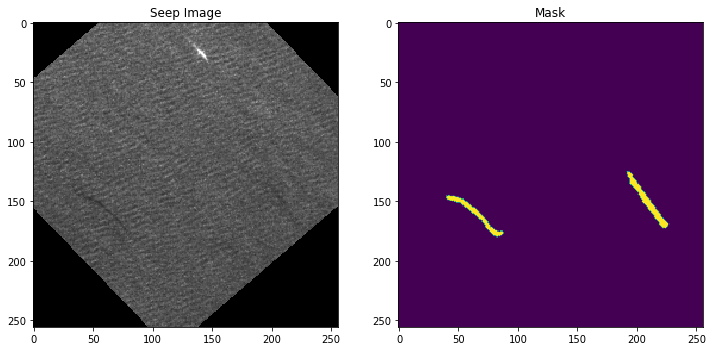

In [8]:
for img, mask in train_generator:
    mask_test = mask[0][:,:,0]
    img_test = img[0]
    break

plot_image_mask(img_test, mask_test)

## Modeling

In [11]:
from models import *

# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# model = get_unet()
model = unet()

model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[iou_metric])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## Training

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    validation_steps=100,
    callbacks=[early_stopping],
    epochs=150)

Epoch 1/150
39/39 [==============================] - 84s 2s/step - loss: 1.2585 - iou_metric: 0.0000e+00 - val_loss: 1.1879 - val_iou_metric: 0.0127
Epoch 2/150
39/39 [==============================] - 76s 2s/step - loss: 1.0365 - iou_metric: 0.0022 - val_loss: 3.6422 - val_iou_metric: 0.0000e+00
Epoch 3/150
39/39 [==============================] - 72s 2s/step - loss: 0.8907 - iou_metric: 0.0164 - val_loss: 1.0406 - val_iou_metric: 0.0000e+00
Epoch 4/150
39/39 [==============================] - 72s 2s/step - loss: 0.7645 - iou_metric: 0.0483 - val_loss: 1.7668 - val_iou_metric: 0.0228
Epoch 5/150
39/39 [==============================] - 72s 2s/step - loss: 0.6720 - iou_metric: 0.0530 - val_loss: 0.6313 - val_iou_metric: 0.0316
Epoch 6/150
39/39 [==============================] - 72s 2s/step - loss: 0.5858 - iou_metric: 0.0656 - val_loss: 0.6894 - val_iou_metric: 0.0127
Epoch 7/150
39/39 [==============================] - 72s 2s/step - loss: 0.5917 - iou_metric: 0.0761 - val_loss: 0.632

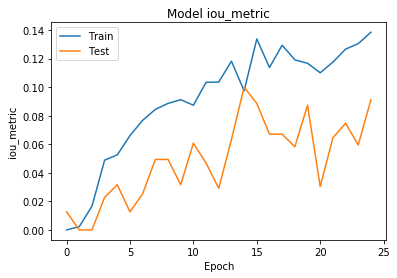

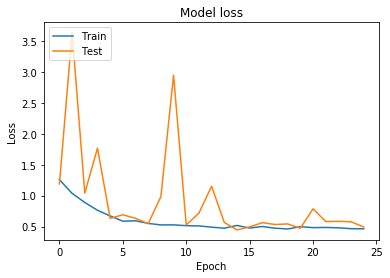

In [15]:
# # Plot training & validation accuracy values
plt.plot(history.history['iou_metric'])
plt.plot(history.history['val_iou_metric'])
plt.title('Model iou_metric')
plt.ylabel('iou_metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()




Sample 1


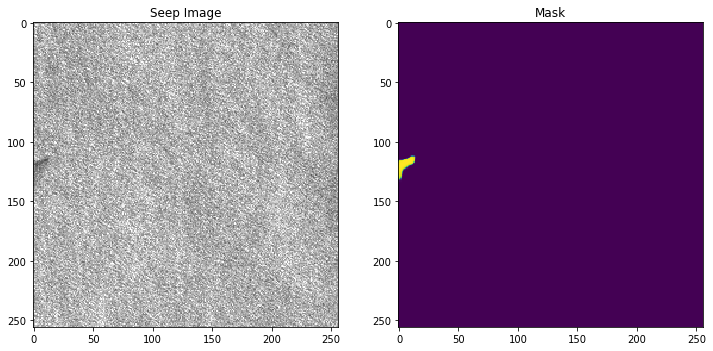

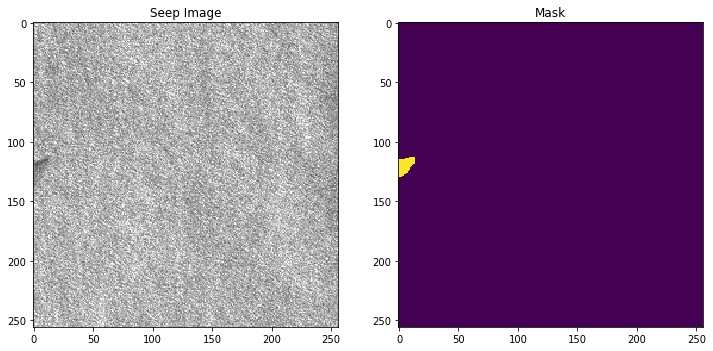




Sample 2


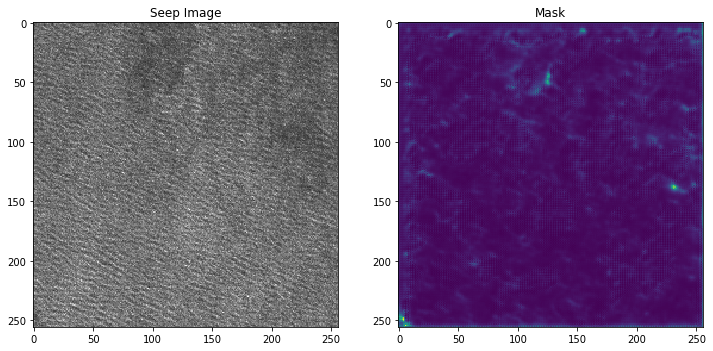

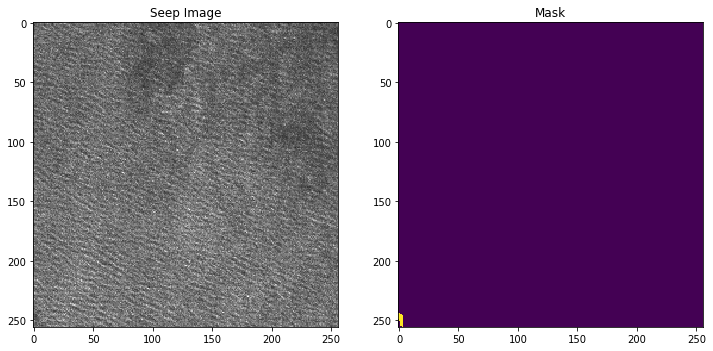




Sample 3


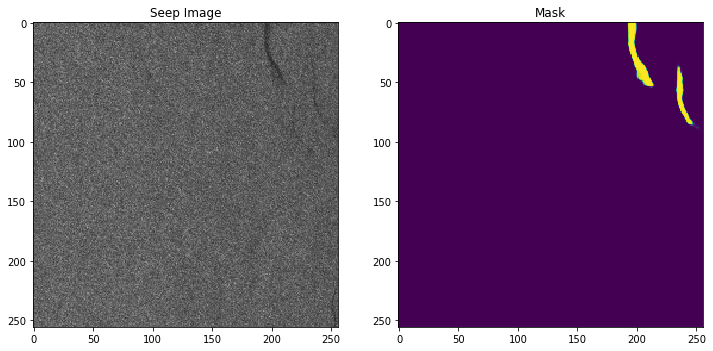

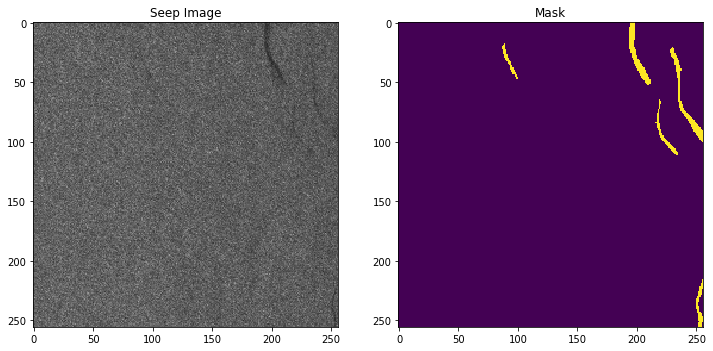




Sample 4


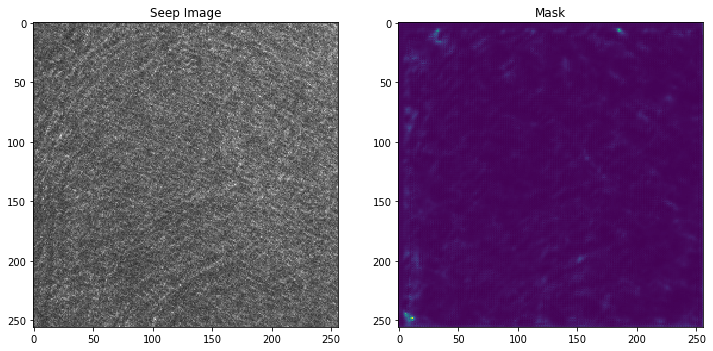

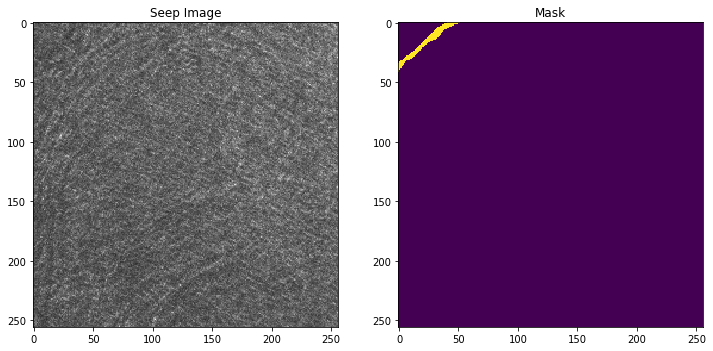




Sample 5


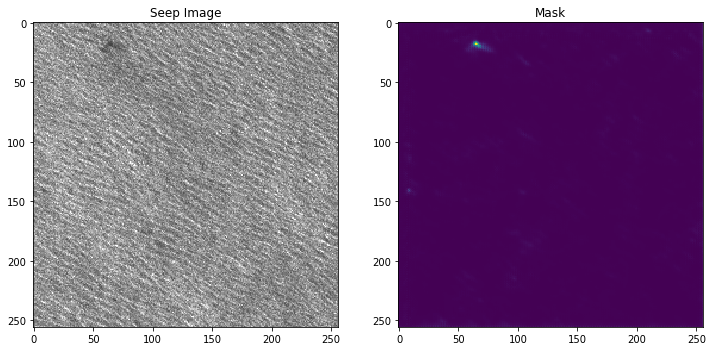

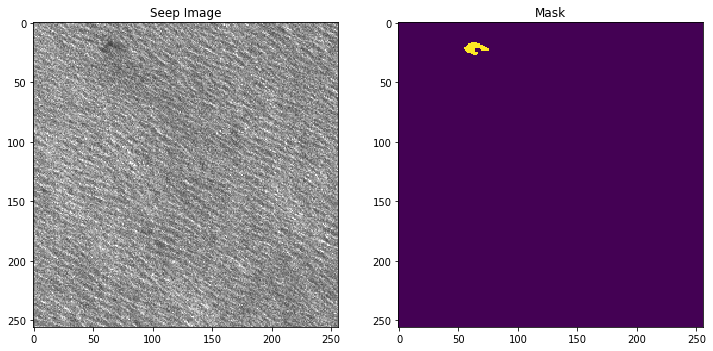




Sample 6


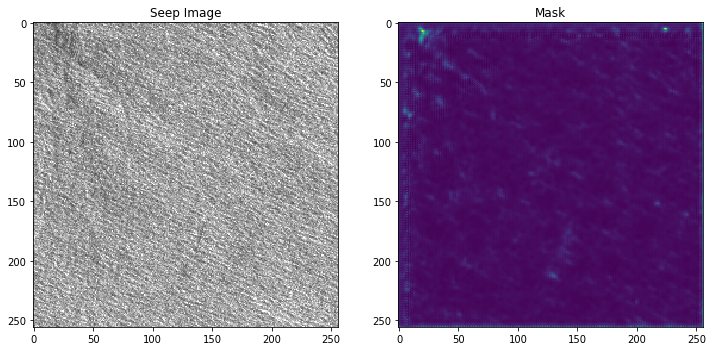

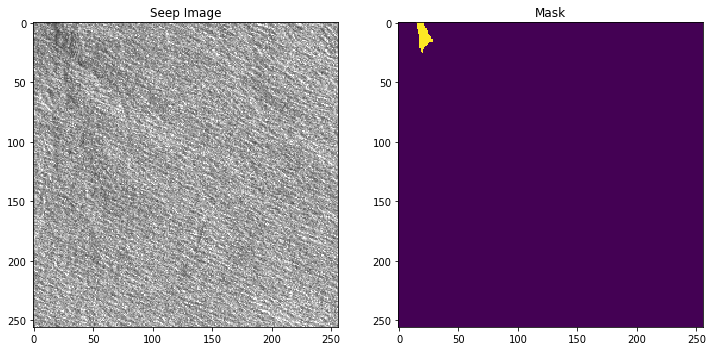




Sample 7


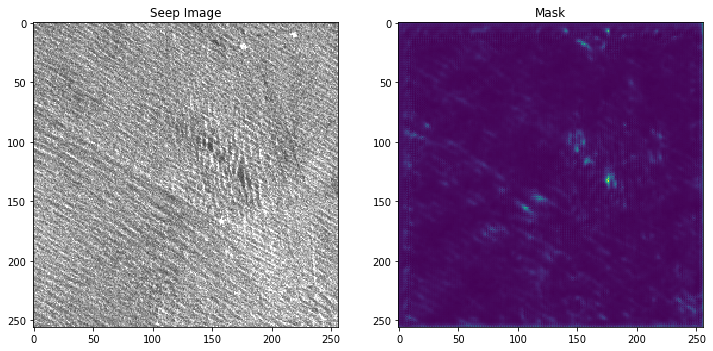

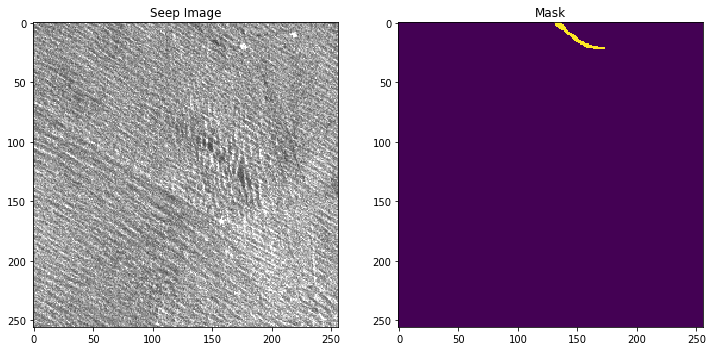




Sample 8


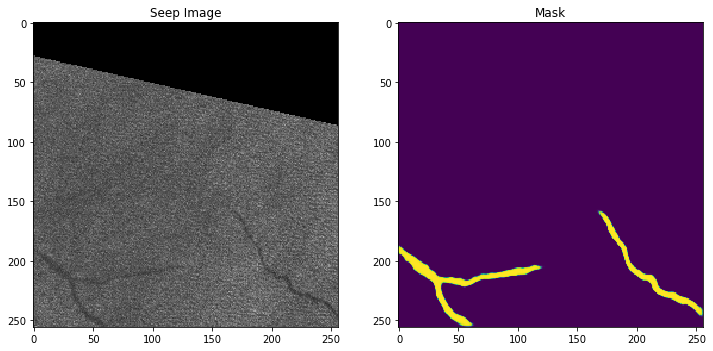

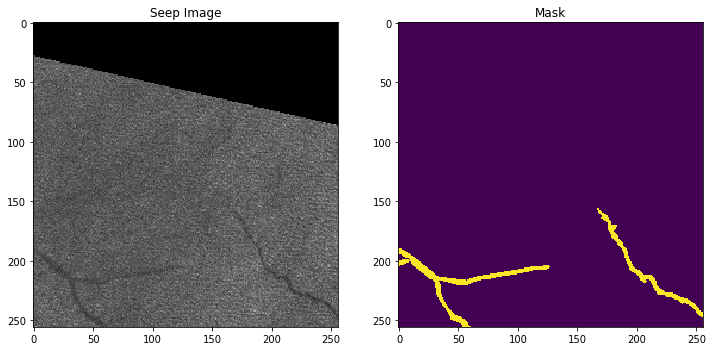




Sample 9


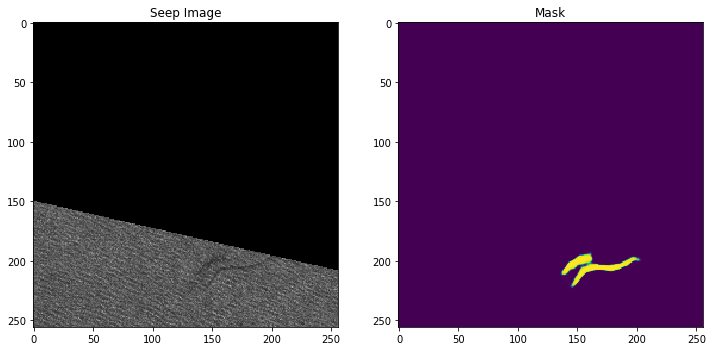

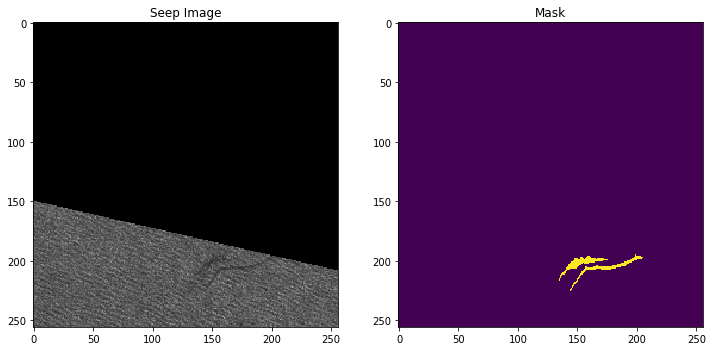

In [17]:
preds = model.predict(X_test)

for idx in range(1,10):
  print("\n\n\nSample {}".format(idx))
  plot_image_mask(X_test[idx], preds[idx][:,:,0])
  plot_image_mask(X_test[idx], y_test[idx][:,:,0])